In [11]:
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
from time import time
import io
import re

import pickle
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import plot_model

# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

from datetime import datetime
from collections import defaultdict

from sklearn.model_selection import train_test_split



In [5]:
# from transformers import BertTokenizer, TFBertModel

In [6]:
from transformers import BertTokenizer, TFBertForMultipleChoice, TFBertForSequenceClassification, TFBertModel

# Data

In [40]:
train_section = pd.read_table("train_dataset.csv", sep='\t', index_col=0)
val_section = pd.read_table("val_dataset.csv", sep='\t', index_col=0)
test_section = pd.read_table("test_dataset.csv", sep='\t', index_col=0)

In [41]:
test_section.head()

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,democrat.bias,republican.bias,biaslabel,isbiased,biascategories,text,label
7048,http://news.yahoo.com/virginia-republicans-pan...,News,1,Elections,Republican Scandals,SomewhatPositive,Negative,a minister who compared gays to pedophiles and...,600,0.5,-1.0,Very Liberal,1,1,a minister who compared gays to pedophiles and...,Biased
2861,http://www.dailykos.com/story/2013/01/17/11796...,Opinion,0,Gun Rights Regulation,Gun Related Crimes,Neutral,Neutral,nra ad: are the president's kids more importan...,600,0.0,0.0,Neutral,0,0,nra ad: are the president's kids more importan...,Neutral
7023,http://www.washingtonpost.com/opinions/george-...,Opinion,0,International News,Gun Rights Regulation,Negative,Neutral,back to previous page obama hits a wall in ber...,600,-1.0,0.0,Conservative,1,-1,back to previous page obama hits a wall in ber...,Biased
8486,http://news.yahoo.com/gop-infighting-fierce-ev...,Opinion,0,Republican Scandals,None,SomewhatPositive,SomewhatNegative,"montpelier, idaho (ap) — republicans have made...",600,0.5,-0.5,Liberal,1,1,"montpelier, idaho (ap) — republicans have made...",Biased
9055,http://www.latimes.com/news/nationworld/nation...,News,1,Elections,None,Positive,Neutral,washington — finally unburdened by worries abo...,600,1.0,0.0,Liberal,1,1,washington — finally unburdened by worries abo...,Biased


In [1]:
test_labels = [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]

## Model Results

In [28]:
bert_predictions = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0]

In [29]:
# copied from roberta notebook
roberta_predictions = [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0]

In [30]:
frozenroberta_predictions = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0]

In [31]:
# copied from xlnet notebook
xlnet_predictions = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0]

In [32]:
frozenxlnet_predictions = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0]

In [57]:
albert_predictions = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]

In [83]:
predictions = [bert_predictions, roberta_predictions, xlnet_predictions, albert_predictions]
names = ["BERT", "RoBERTa",  "XLNet", "ALBERT"]

# predictions = [bert_predictions, roberta_predictions, frozenroberta_predictions, xlnet_predictions, frozenxlnet_predictions]
# names = ["BERT", "RoBERTa", "RoBERTa (6 layers trained)", "XLNet", "XLNet (6 layers trained)"]

In [84]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [85]:
modelaccuracylist = []
modelnamelist = []
modelprecisionlist = []
modelrecalllist = []
modelf1list = []
mlist = []
for i in range(len(predictions)):
    test_classes = predictions[i]
    modelname = names[i]
    modelnamelist.append(modelname)
    print(modelname +" Metrics:")
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(test_labels, test_classes)
    print('Accuracy: %f' % accuracy)
    modelaccuracylist.append(accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(test_labels, test_classes)
    print('Precision: %f' % precision)
    modelprecisionlist.append(precision)
    # recall: tp / (tp + fn)
    recall = recall_score(test_labels, test_classes)
    print('Recall: %f' % recall)
    modelrecalllist.append(recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(test_labels, test_classes)
    modelf1list.append(f1)
    print('F1 score: %f' % f1)
    mlist.append([accuracy, precision, recall, f1])
    print("")
 

BERT Metrics:
Accuracy: 0.745455
Precision: 0.742857
Recall: 0.838710
F1 score: 0.787879

RoBERTa Metrics:
Accuracy: 0.763636
Precision: 0.800000
Recall: 0.774194
F1 score: 0.786885

XLNet Metrics:
Accuracy: 0.809091
Precision: 0.805970
Recall: 0.870968
F1 score: 0.837209

ALBERT Metrics:
Accuracy: 0.681818
Precision: 0.721311
Recall: 0.709677
F1 score: 0.715447



In [89]:
df = pd.DataFrame(columns = modelnamelist)
df.loc['Accuracy'] = modelaccuracylist
df.loc['Precision'] = modelprecisionlist
df.loc['Recall'] = modelrecalllist
df.loc['F1'] = modelf1list
df.head()

,BERT,RoBERTa,XLNet,ALBERT
Accuracy,0.745455,0.763636,0.809091,0.681818
Precision,0.742857,0.800000,0.805970,0.721311
Recall,0.838710,0.774194,0.870968,0.709677
F1,0.787879,0.786885,0.837209,0.715447


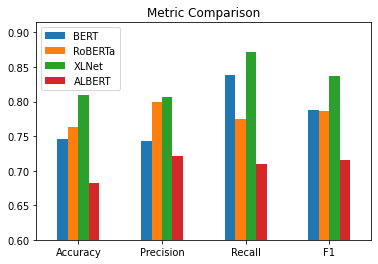

In [92]:
ax = df.plot.bar(rot=0)
ax.set_ylim(ymin=0.6)
plt.title('Metric Comparison')
# plt.show()
plt.savefig('modelmetriccomparison.jpg')

In [93]:
bertmodeldata = pd.read_table("bertmodeldata.csv", sep='\t', index_col=0)
robertamodeldata = pd.read_table("robertamodeldata.csv", sep='\t', index_col=0)
# frozenrobertamodeldata = pd.read_table("frozenrobertamodeldata.csv", sep='\t', index_col=0)
xlnetmodeldata = pd.read_table("xlnetmodeldata.csv", sep='\t', index_col=0)
# frozenxlnetmodeldata = pd.read_table("frozenxlnetmodeldata.csv", sep='\t', index_col=0)
albertmodeldata = pd.read_table("albertmodeldata.csv", sep='\t', index_col=0)


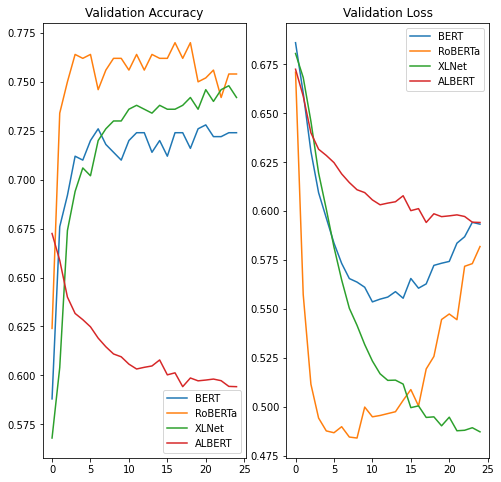

In [94]:
bert_val_acc = bertmodeldata['ValAccuracy']
roberta_val_acc = robertamodeldata['ValAccuracy']
xlnet_val_acc = xlnetmodeldata['ValAccuracy']
albert_val_acc = albertmodeldata['ValAccuracy']

bert_val_loss = bertmodeldata['Val_loss']
roberta_val_loss = robertamodeldata['Val_loss']
# frozenroberta_val_loss = frozenrobertamodeldata['Val_loss']
xlnet_val_loss = xlnetmodeldata['Val_loss']
# frozenxlnet_val_loss = frozenxlnetmodeldata['Val_loss']
albert_val_loss = albertmodeldata['Val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, bert_val_acc, label='BERT')
plt.plot(epochs_range, roberta_val_acc, label='RoBERTa')
# plt.plot(epochs_range, frozenroberta_val_acc, label='RoBERTa (6 layers trained)')
plt.plot(epochs_range, xlnet_val_acc, label='XLNet')
plt.plot(epochs_range, albert_val_loss, label='ALBERT')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, bert_val_loss, label='BERT')
plt.plot(epochs_range, roberta_val_loss, label='RoBERTa')
# plt.plot(epochs_range, frozenroberta_val_loss, label='RoBERTa (6 layers trained)')
plt.plot(epochs_range, xlnet_val_loss, label='XLNet')
plt.plot(epochs_range, albert_val_loss, label='ALBERT')
plt.legend(loc='upper right')
plt.title('Validation Loss')
# plt.show()
plt.savefig('modeltrainingcomparison.jpg')

In [ ]:
# plot accuracy

In [ ]:
def findcommonlabel(label, predictionlist):
    labellist = []
    for i in range(len(predictionlist[1])):
        allin = True
        labeli = predictionlist[0][i]
        for ii in range(len(predictionlist)):
            if predictionlist[ii][i] !=labeli:
                allin = False
        if allin == True:
            labellist.append(i)
    return labelist

In [ ]:
allbiased = findcommonlabel(0, predictionlist)

In [8]:
MAX_LEN = 512
nepochs = 25
nbatch = 5

In [9]:
data_dir = "./data"
log_dir = f"{data_dir}/experiments/logs"
save_path = f"{data_dir}/experiments/BinaryBERTmodels"
cache_path_train = f"{data_dir}/cache/BinaryBERTmodel.train"
cache_path_test = f"{data_dir}/cache/BinaryBERTmodel.test"

## Transforming Data

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels = np.asarray(le.fit_transform(train_section['label']))
val_labels = np.asarray(le.transform(val_section['label']))
# train_labels = np.asarray(train_section['label'])
# val_labels = np.asarray(val_section['label'])

# train_labels = np.asarray(train_section['democrat.bias']+1)
# val_labels = np.asarray(val_section['democrat.bias']+1)

In [11]:
# le.inverse_transform(val_labels)[:20]

In [12]:
len(np.unique(train_labels))

2

In [13]:
tokenizer_transformer = BertTokenizer.from_pretrained('bert-large-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [14]:
# Initialise Bert Tokenizer

def create_input_array(df, tokenizer):
    sentences = df.text.values

    input_ids = []
    attention_masks = []
    token_type_ids = []

    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
            sent,  # Sentence to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=MAX_LEN,  # Pad & truncate all sentences.
                pad_to_max_length=True,
                return_attention_mask=True,  # Construct attn. masks.
                return_tensors='tf',  # Return tf tensors.
            )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

        token_type_ids.append(encoded_dict['token_type_ids'])

    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    token_type_ids = tf.convert_to_tensor(token_type_ids)


    return input_ids, attention_masks, token_type_ids



In [15]:
train_inputs = [create_input_array(train_section, tokenizer=tokenizer_transformer)]
val_inputs = [create_input_array(val_section, tokenizer=tokenizer_transformer)]

# train_inputs = [create_input_array(list(train_section["text"]), tokenizer=bert_tokenizer_transformer)]
# val_inputs = [create_input_array(list(val_section["text"]), tokenizer=bert_tokenizer_transformer)]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2068: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [16]:
def convert_inputs_to_tf_dataset(inputs):
    # args.max_seq_len = 256
    ids = inputs[0][0]
    masks = inputs[0][1]
    token_types = inputs[0][2]

    ids = tf.reshape(ids, (-1, MAX_LEN))
    print("Input ids shape: ", ids.shape)
    masks = tf.reshape(masks, (-1, MAX_LEN))
    print("Input Masks shape: ", masks.shape)
    token_types = tf.reshape(token_types, (-1, MAX_LEN))
    print("Token type ids shape: ", token_types.shape)

    ids=ids.numpy()
    masks = masks.numpy()
    token_types = token_types.numpy()

    return [ids, masks, token_types]

In [17]:
train_data = convert_inputs_to_tf_dataset(train_inputs)
val_data = convert_inputs_to_tf_dataset(val_inputs)

Input ids shape:  (4000, 512)
Input Masks shape:  (4000, 512)
Token type ids shape:  (4000, 512)
Input ids shape:  (500, 512)
Input Masks shape:  (500, 512)
Token type ids shape:  (500, 512)


In [18]:
train_data

[array([[  101,  2899,  1516, ...,  2216,  2024,   102],
        [  101,  2022,  4783, ...,  2000,  5865,   102],
        [  101,  2160, 10643, ...,  3513,  1010,   102],
        ...,
        [  101,  2899,  1011, ...,  2478, 11744,   102],
        [  101,  3120,  2048, ..., 18079,  2003,   102],
        [  101,  4092,  1999, ...,     0,     0,     0]], dtype=int32),
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)]

In [19]:
val_section[val_section['label']=='Neutral'].shape[0]/val_section.article.shape[0]

0.546

In [20]:
model = TFBertForSequenceClassification.from_pretrained('bert-large-uncased',num_labels=len(np.unique(train_labels)))

Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  335141888 
_________________________________________________________________
dropout_73 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  2050      
Total params: 335,143,938
Trainable params: 335,143,938
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-07, epsilon=1e-08)

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history = model.fit(x = train_data, 
          y = train_labels,
          validation_data= (val_data, val_labels), 
          epochs = 25, 
          batch_size = 5)

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - 335s 399ms/step - loss: 0.7060 - accuracy: 0.4931 - val_loss: 0.6861 - val_accuracy: 0.5880
Epoch 2/25
800/800 [==============================] - 322s 403ms/step - loss: 0.6897 - accuracy: 0.5486 - val_lo

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
# plt.show()
plt.savefig('bertlargebinary.jpg')

In [ ]:
bertmodeldata = pd.DataFrame(list(zip(acc, val_acc, loss, val_loss)),
               columns =['Accuracy', 'ValAccuracy', 'Loss', 'Val_loss'])
bertmodeldata.head()

In [ ]:
bertmodeldata.to_csv("bertmodeldata.csv", sep='\t')

In [29]:
test_section.shape

(110, 16)

In [38]:
test_section = test_section[:110]
test_section.shape

(110, 16)

In [30]:
test_labels = np.asarray(le.transform(test_section['label']))
test_inputs = [create_input_array(test_section, tokenizer=tokenizer_transformer)]
test_data = convert_inputs_to_tf_dataset(test_inputs)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2068: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Input ids shape:  (110, 512)
Input Masks shape:  (110, 512)


In [40]:
print("Evaluate on test data")
results = model.evaluate(test_data, test_labels, batch_size=5)
print("test loss, test acc:", results)


Evaluate on test data
22/22 [==============================] - 3s 113ms/step - loss: 0.4754 - accuracy: 0.7636
test loss, test acc: [0.47536763548851013, 0.7636363506317139]


In [44]:
# predict probabilities for test set
test_probs = testmodel.predict(test_data, batch_size= 1, verbose=0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [31]:
test_probs = model.predict(test_data, batch_size= 1, verbose=0)

In [32]:
test_probs = test_probs["logits"]

In [33]:
test_classes = np.argmax(test_probs, axis = 1)

In [34]:
test_classes

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0])

In [35]:
test_labels

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0])

In [36]:
c=0
for i in range(test_classes.shape[0]):
    if test_classes[i]==test_labels[i]:
        c+=1
print("Test accuracy:")
print(c/test_labels.shape[0])

Test accuracy:
0.7636363636363637


In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [38]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_labels, test_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_labels, test_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_labels, test_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels, test_classes)
print('F1 score: %f' % f1)
 

Accuracy: 0.763636
Precision: 0.800000
Recall: 0.774194
F1 score: 0.786885


In [39]:
train_section.to_csv("train_dataset.csv", sep='\t')
val_section.to_csv("val_dataset.csv", sep='\t')
test_section.to_csv("test_dataset.csv", sep='\t')

In [ ]:
model.save_pretrained(save_path)

In [77]:
tf.keras.backend.clear_session()